(chap_formation_overview)=
# From photons to pixels

:::{admonition} Chapter outline 
:class: tip

* The **pixel values** in a fluorescence image depend upon **numbers of detected photons** 
* Our images can't be perfect: **blur & noise** are inevitable 
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

One of the most common imaging modalities associated with bioimage analysis is fluorescence microscopy.
Applying the analysis techniques described in this book meaningfully to fluorescence images involves understanding a bit about the imaging process.

Part III aim to provide an introduction to the main ideas, along with some useful mental models to help relate analysis techniques to imaging realities.
These ideas can help with figuring out how to acquire and analyze fluorescence microscopy data in scientifically justifiable ways.

## The big picture of fluorescence imaging 

Images in fluorescence microscopy are formed by detecting light.
The amounts of light involved are so small that they can be thought of in terms of individual photons.

The photons are emitted from fluorescent molecules within the sample being imaged.
Sometimes these photon-emitting molecules may be the very things we are interested in studying, but often they have only been introduced to the sample because they have the helpful property of fluorescing in the presence of the (otherwise non-fluorescent) molecules or structures we would _really_ like to see. 

Either way, the most that the image can tell us is how much light was emitted from any particular point in the sample.
From this information we make our interpretations, such as about the presence of absence of some feature, about the size and shape of a structure, or about the relative concentration of a molecule.
But in no case are we *seeing* the feature, structure or molecule directly in the recorded images: we only have measurements of the numbers of photons we could detect, encoded in pixel values. 

We won't give much attention here to what any particular number of photons emanating from a sample really indicates from a biological point of view -- this would depend too much upon the design and details of the experiment, i.e. on the cells, stains and other substances involved.
We can, however, often make general assumptions.
One such assumption is that if we were to see (on average) twice as many photons originating from one region as from another, the number of fluorescing molecules must be around twice as high in the first region [^fn_1].
But before we can worry about such things, we should consider how accurately we can even determine the number and origins of photons being emitted from the sample in the first place, given the limited quality of the images we can actually record. 

[^fn_1]: This assumes a linear relationship, which does not always hold (e.g. if there's dye saturation, or high laser powers are used for illumination).

### Recording images 

We already introduced a simple model of fluorescence image formation in {ref}`chap_pixels` with two animations.
The first animation shows the overall process:

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/simple_microscope.mp4" type="video/mp4">
</video>

The second animation zooms in to give more detail on photon detection, and how this ultimately leads to pixel values being stored in a digital image:

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/simple_camera.mp4" type="video/mp4">
</video>

It will be helpful to keep this model in mind throughout the following sections.

Once a sample has been prepared and is waiting underneath the microscope, the basic process of recording a fluorescence image comprises four main steps: 

1.  **Fluorophore excitation.** The fluorescent molecules (fluorophores) first need to be raised into an excited state.
This happens upon the absorption of a photon, the energy (i.e.
wavelength) of which should fall into a range specific to the fluorophore itself.
This is carried out by illuminating the sample, e.g. with a lamp or laser. 
2.  **Photon emission.** When returning to its ground state, each fluorophore may emit a photon –- this time with a lower energy (i.e. longer wavelength) than the photon previously absorbed. 
3.  **Photon detection.** Most emitted photons can be thought of, rather informally, as 'shooting off in the wrong direction', in which case we have no hope of detecting them.
But a proportion of the light should enter the objective lens of the microscope and be focussed towards a detector.
When a photon strikes the detector, it is registered as a 'hit' by the release of an electron (if we're lucky; detectors are imperfect so this might not occur, meaning the photon is effectively lost). 
4.  **Quantification & storage.** After fixed time intervals, the charges of the electrons produced by photons striking the detector are quantified, and from these quantifications pixel values are determined. A larger charge indicates more photons, which translates into a higher pixel value.

### Errors and imprecisions 

From the above summary, it's clear that we are quite some distance away from knowing exactly how much light is emitted from the sample: most photons do not reach the detector, and many that do are still not registered.
But since we can expect to always lose track of a similar proportion of emitted light -- perhaps as much as 90% -- this does not matter much: we can expect all parts of the image to be similarly affected, so relative differences in brightness would still be reflected in our pixel values.

However, this isn't our only limit.
There are two more critical ways in which the images we can record are worse than the images we would like: 


1.  **Uncertainty in space.** Ideally, all light originating from a particular point in the sample would strike the detector in exactly the same place, and therefore contribute to exactly the same pixel.
In practice, however, _the light originating from one point can't be focused back to a single point on the detector_.
Consequently, it can end up being spread over several pixels.
The end result is that the image is _blurred_. 
2.  **Uncertainty in brightness.** When an image is blurry we would also expect it to be smooth, but this is not usually what we get in fluorescence microscopy.
Rather, there are seemingly random variations in brightness everywhere throughout the image: the _noise_.
Some noise can come from imprecisions when determining the charge of small clouds of electrons quickly.
But, more fundamentally, _the emission of the photons is itself random_.
This means that even if we could detect every photon perfectly we would *still* get noisy images. 

These issues are depicted in {numref}`fig-colored_spots`.

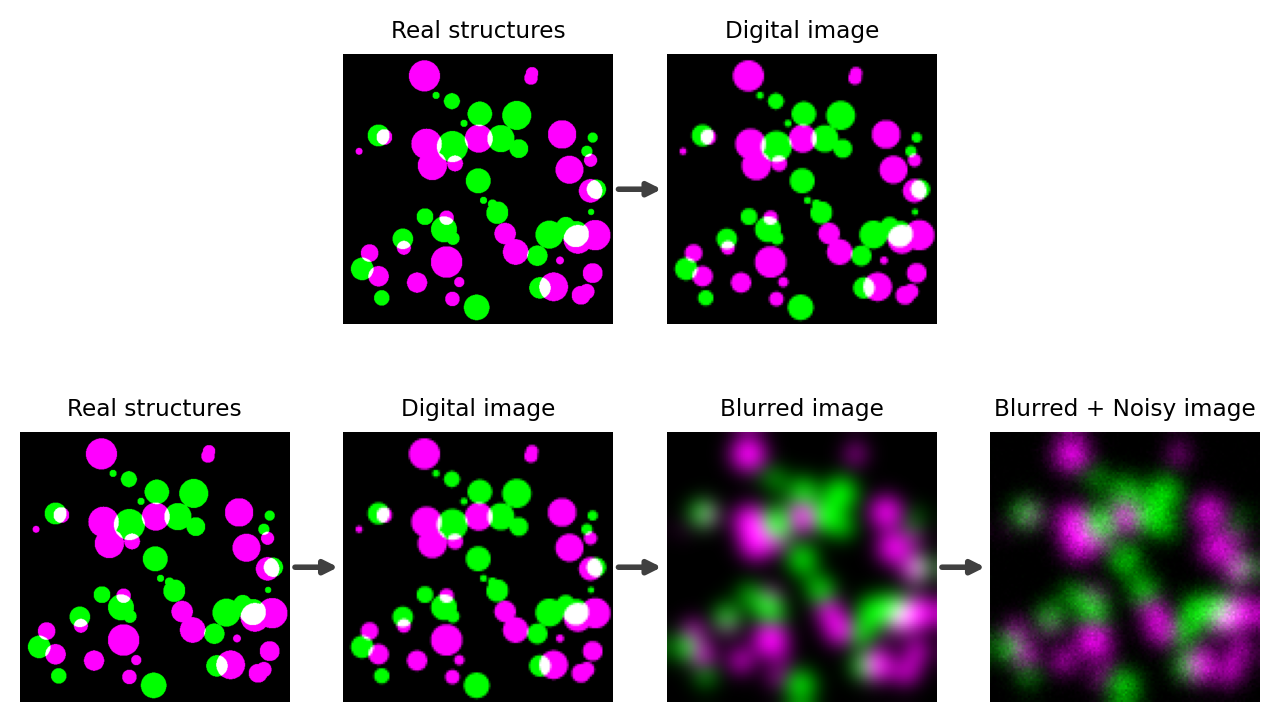

In [2]:
fig = create_figure(figsize=(8, 4.5))

from skimage import draw
from skimage.transform import downscale_local_mean, rescale

def create_random_disks(shape, rng, n=10, min_radius=5, max_radius=15, dtype=np.float32):
    """
    Create random circular objects
    """
    im = np.zeros(shape, dtype=dtype)
    for ii in range(n):
        radius = min_radius + rng.random() * (max_radius - min_radius)
        cx = max_radius + np.floor(rng.random() * (shape[1] - max_radius*2))
        cy = max_radius + np.floor(rng.random() * (shape[0] - max_radius*2))
        coords = draw.disk((cy, cx), radius, shape=shape)
        im[coords] = 1.0
    return im

# Create an 'ideal' 2-channel image of structures (at high resolution)
size = 512
min_radius = 5
max_radius = 30
rng = np.random.default_rng(100)
n = 30
im_structures = np.dstack((
    create_random_disks((size, size), rng=rng, n=n, min_radius=min_radius, max_radius=max_radius),
    create_random_disks((size, size), rng=rng, n=n, min_radius=min_radius, max_radius=max_radius)
))

# Create a (lower-resolution) rasterized version
im_rasterized = downscale_local_mean(im_structures, (4, 4, 1))

# Simulate blur with PSF
sigma = 5
im_blurred = ndimage.gaussian_filter(im_rasterized, sigma=(sigma, sigma, 0)) * (2*np.pi*sigma*sigma)

# Simulate Poisson noise
im_noisy = rng.poisson(1 + im_blurred * 2)

# Convert to RGB
im_structures = create_rgb(im_structures, (('green', 'magenta')))
im_rasterized = create_rgb(im_rasterized, (('green', 'magenta')))
im_blurred = create_rgb(im_blurred, vmin=np.percentile(im_blurred, 0.01), vmax=np.percentile(im_blurred, 99.99), colors=(('green', 'magenta')))
im_noisy = create_rgb(im_noisy, vmin=np.percentile(im_noisy, 0.01), vmax=np.percentile(im_noisy, 99.99), colors=(('green', 'magenta')))

# Show images

def connect_axes(axA, axB):
    """
    Draw an arrow between two axes
    """
    from matplotlib.patches import ConnectionPatch
    con = ConnectionPatch(xyA=(1.02, 0.5), xyB=(-0.02, 0.5), coordsA=axA.transAxes, coordsB=axB.transAxes, 
                          arrowstyle="-|>", color=(0.25,)*3, linewidth=2, axesA=axA, axesB=axB)
    # fig.axes[1].add_artist(con)
    axB.add_artist(con)

show_image(im_structures, title='Real structures', pos=242)
show_image(im_rasterized, title='Digital image', pos=243)
connect_axes(fig.axes[-2], fig.axes[-1])

show_image(im_structures, title='Real structures', pos=245)
show_image(im_rasterized, title='Digital image', pos=246)
connect_axes(fig.axes[-2], fig.axes[-1])
show_image(im_blurred, title='Blurred image', pos=247)
connect_axes(fig.axes[-2], fig.axes[-1])
show_image(im_noisy, title='Blurred + Noisy image', pos=248)
connect_axes(fig.axes[-2], fig.axes[-1])

glue_fig('fig_imaging_colored_spots', fig)

```{glue:figure} fig_imaging_colored_spots
---
align: center
name: fig-colored_spots
---
The difference between what we might wish to image, and what we actually can image. *(Top)* Ideally, the small colored spots in reality would directly map to colored spots of a related size and separation in the image. This would make measuring the structures relatively straightforward: whatever we measure in the image accurately corresponds to the reality. *(Bottom)* In practice, the light emitted from our real structures would actually end up producing larger, blurry objects in the image with noise added on top. The *Blurred + Noisy* image then represents what we can *actually* acquire with a light microscope. For analysis, we need to use this decidedly imperfect image to try to figure out what the measurements of the real structures should be.
``` 

The twin issues of blur and noise do not affect all images equally.
For example, blur can cause us to misjudge the size of something by several hundred nanometers; if the thing we are measuring is much larger than this then the relative error may be trivial, but if it is smaller then the relative error may be huge.
Similarly, if we are detecting many thousands of photons then the uncertainty due to noise may be extremely small relative to the numbers involved, but if we have few photons then noise could dominate our results.

The biggest challenges arise whenever we are interested in measuring tiny structures in images containing only tens of photons at their brightest points.
This is inconventiently common.
In such cases, the effects of blur and noise can't be ignored. 

The good news is that image processing can help us.
However, we need to understand the problem so that we can choose appropriate processing techniques to apply.
For that reason, the next two chapters will describe blur and noise in more detail -- and point towards ways we can deal with them.